In [303]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.optimizers import SGD

def separate_training_testing(x_data, y_data, train_size):

    big_matrix = np.concatenate((x_data, y_data), axis=1)
    np.random.shuffle(big_matrix)

    x_train = big_matrix[:train_size,:x_data.shape[1]]
    y_train = big_matrix[:train_size,x_data.shape[1]:]
    x_test = big_matrix[train_size:,:x_data.shape[1]]
    y_test = big_matrix[train_size:,x_data.shape[1]:]

    return x_train, y_train, x_test, y_test

In [304]:
# x_data: rows are cases, columns are the number of fuel + lbp columns
# y_data: rows are cases, column are 2: max ppf + keff_20y

input_data = pd.read_csv('lbp_data.csv', index_col=['Unnamed: 0'])
x_data = input_data.to_numpy().T

# Keff data
input_data = pd.read_csv('keff_data.csv', index_col=['Unnamed: 0'])
y_data_keff = input_data.to_numpy().T

y_data_keff_max = np.amax(y_data_keff)
y_data_keff_normal = y_data_keff/y_data_keff_max

# Power distribution data
ave_power_sixth = 15e6/(12*48+24*54) * 164
input_data = pd.read_csv('pp_data.csv', index_col=['Unnamed: 0'])
y_data_ppf = input_data.to_numpy().T

total_nonzeros = np.count_nonzero(y_data_ppf, axis=1)
ave_power = ave_power_sixth/(total_nonzeros)
y_data_ppf = y_data_ppf/np.outer(ave_power, np.ones(y_data_ppf.shape[1]))

# y_data_maxppf = np.amax(y_data_ppf, 1)

# normalize everything to the max ppf
y_data_ppf_max = np.amax(y_data_ppf)
y_data_ppf_normal = y_data_ppf/y_data_ppf_max

# right now we will try to calculate with the ANN the max ppf
# remove this two lines if wanting to compute all the ppf
y_data_ppf_normal = np.amax(y_data_ppf_normal, 1)
y_data_ppf_normal = y_data_ppf_normal.reshape(len(y_data_ppf_normal), 1)

# y_data = np.concatenate((y_data_ppf_normal, y_data_keff_normal), axis=1)
y_data = y_data_ppf_normal

# Let's try with my own ANN

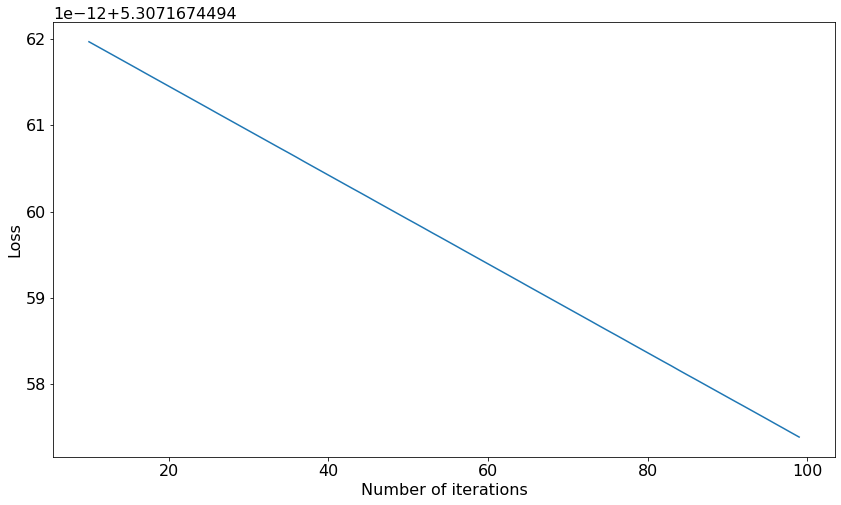

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [305]:
def f1(x):
    # Sigmoid
    return 1./(1.+np.exp(-x))
    # ReLu
    # if x > 0:
    #     return x
    # else:
    #     return 0    

def der_f1(x):
    # Derivative of sigmoid
    return f1(x) * (1. - f1(x))
    # Derivative of ReLU
    # if x > 0:
    #    return 1
    # else:
    #    return 0

def f2(x):
    # Sigmoid
    return 1./(1.+np.exp(-x))
    # Linear
    # return x

def der_f2(x):
    # Derivative of sigmoid
    return f2(x) * (1. - f2(x))
    # Derivative of linear
    # return 1

class NeuralNetwork():
    def __init__(self, numberofhiddenn, x, t):
        self.x = x
        self.target = np.reshape(t, (len(t), 1))
        self.weights1 = np.random.rand(x.shape[1], numberofhiddenn)
        self.weights2 = np.random.rand(numberofhiddenn, self.target.shape[1])
        self.biases1 = np.zeros((1, numberofhiddenn))
        self.biases2 = np.zeros((1, self.target.shape[1]))
        self.eta = 1.

    def feedforward(self):
        vec1 = np.vectorize(f1)
        self.z1 = self.x @ self.weights1 + self.biases1
        self.a1 = vec1(self.z1)
        self.z2 = self.a1 @ self.weights2 + self.biases2
        self.a2 = f2(self.z2)

    def backpropagation(self):
        # vec1 = np.vectorize(der_f1)
        # vec2 = np.vectorize(der_f2)

        dC_dW2i = np.dot(self.a1.T, 2 * (self.a2-self.target) * der_f2(self.z2))
        dC_db2i = np.dot(np.ones(len(self.target)), 2 * (self.a2-self.target) * der_f2(self.z2))
        dC_dW1ji = np.dot(self.x.T, (2 * (self.a2-self.target) * der_f2(self.z2) @ self.weights2.T) * der_f1(self.z1))
        dC_db1i = np.dot((2 * (self.a2-self.target) * der_f2(self.z2)).T, der_f1(self.z1)) * self.weights2.T

        self.weights1 -= self.eta * dC_dW1ji
        self.weights2 -= self.eta * dC_dW2i
        self.biases1 -= self.eta * dC_db1i
        self.biases2 -= self.eta * dC_db2i
    
    def calc_loss(self):
        self.loss = np.sum((self.target - self.a2)**2)

    def predict(self, x):
        # vec1 = np.vectorize(f1)
        z1 = x @ self.weights1 + self.biases1
        a1 = f1(z1)
        z2 = a1 @ self.weights2 + self.biases2
        a2 = f2(z2)
        return a2

x_train, y_train, x_test, y_test = separate_training_testing(x_data, y_data, 130)
NN = NeuralNetwork(60, x_train, y_train)
    
Loss = []
for i in range(100):
    NN.feedforward()
    NN.backpropagation()
    NN.calc_loss()
    Loss.append(NN.loss)

plt.plot(np.arange(10, 100), Loss[10:])
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

NN.predict(x_test)

# Let's try using Keras

MSE_TRAIN: 0.002602050546556711
MSE_TEST: 0.0031397580169141293


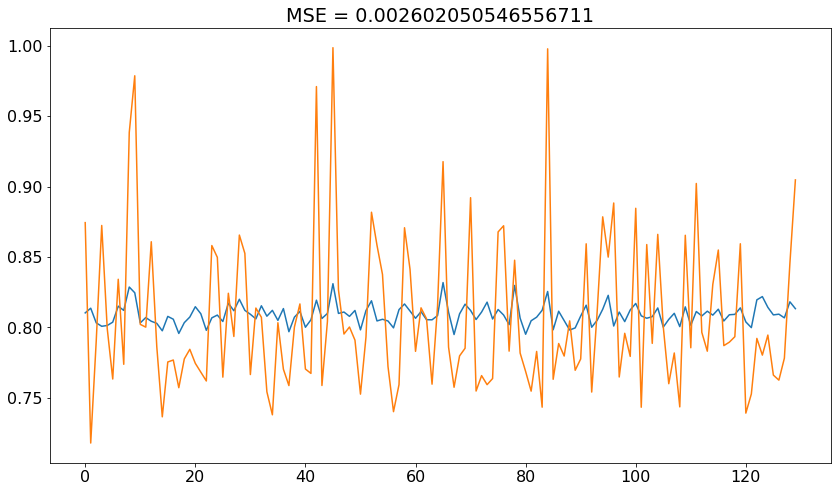

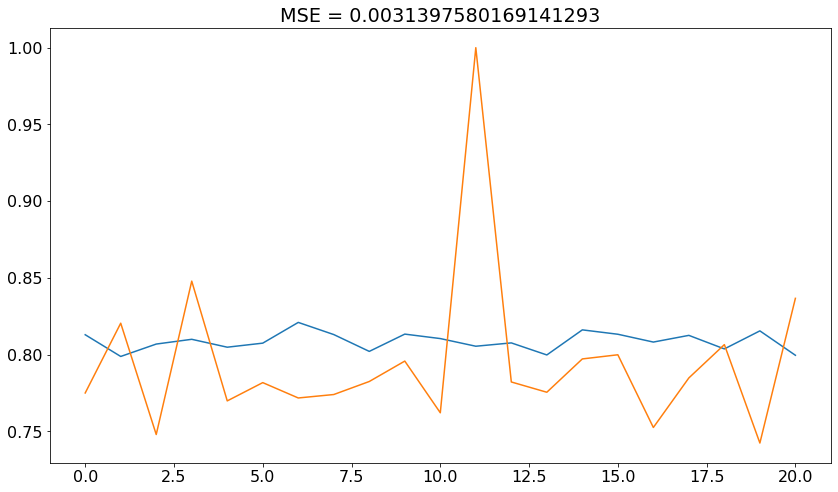

In [306]:
x_train, y_train, x_test, y_test = separate_training_testing(x_data, y_data, 130)

n_cols = x_train.shape[1]
model = Sequential()  # Set up the model: model
model.add(Dense(90, activation='sigmoid', input_shape=(n_cols,)))
model.add(Dense(90, activation='sigmoid'))
model.add(Dense(90, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=15, verbose=0)
mse_train = model.evaluate(x_train, y_train, verbose=0)
mse_test = model.evaluate(x_test, y_test, verbose=0)

print(f'MSE_TRAIN: {mse_train}')
print(f'MSE_TEST: {mse_test}')

y_pred = model.predict(x_train)
y_pred_test = model.predict(x_test)

plt.figure()
plt.plot(np.arange(len(y_pred)), y_pred)
plt.plot(np.arange(len(y_train)), y_train)
plt.title(f'MSE = {mse_train}')

plt.figure()
plt.plot(np.arange(len(y_pred_test)), y_pred_test)
plt.plot(np.arange(len(y_test)), y_test)
plt.title(f'MSE = {mse_test}')
plt.savefig(modelname)

# Let's try preprocessing the y_train a bit more

In [171]:
# x_data: rows are cases, columns are the number of fuel + lbp columns
# y_data: rows are cases, column are 2: max ppf + keff_20y

input_data = pd.read_csv('lbp_data.csv', index_col=['Unnamed: 0'])
x_data = input_data.to_numpy().T

# Keff data
input_data = pd.read_csv('keff_data.csv', index_col=['Unnamed: 0'])
y_data_keff = input_data.to_numpy().T

y_data_keff_max = np.amax(y_data_keff)
y_data_keff_normal = y_data_keff/y_data_keff_max

# Power distribution data
ave_power_sixth = 15e6/(12*48+24*54) * 164
input_data = pd.read_csv('pp_data.csv', index_col=['Unnamed: 0'])
y_data_ppf = input_data.to_numpy().T

total_nonzeros = np.count_nonzero(y_data_ppf, axis=1)
ave_power = ave_power_sixth/(total_nonzeros)
y_data_ppf = y_data_ppf/np.outer(ave_power, np.ones(y_data_ppf.shape[1]))

# right now we will try to calculate with the ANN the max ppf
# remove this two lines if wanting to compute all the ppf
y_data_ppf_normal = np.amax(y_data_ppf_normal, 1)
y_data_ppf_normal = y_data_ppf_normal.reshape(len(y_data_ppf_normal), 1)

# normalize everything to the max ppf
mean = np.mean(y_data_ppf_normal)
std = np.std(y_data_ppf_normal)
y_data = (y_data_ppf_normal - mean)/std

Iteration: 1, MSE: 1.4227417707443237
Iteration: 2, MSE: 0.6893631219863892
Iteration: 3, MSE: 0.7638306021690369
Iteration: 4, MSE: 0.4555586874485016
Iteration: 5, MSE: 0.6403639912605286
Iteration: 6, MSE: 0.9767852425575256
Iteration: 7, MSE: 0.7182595729827881
Iteration: 8, MSE: 0.45512065291404724
Iteration: 9, MSE: 0.9210256338119507
Iteration: 10, MSE: 1.2166132926940918


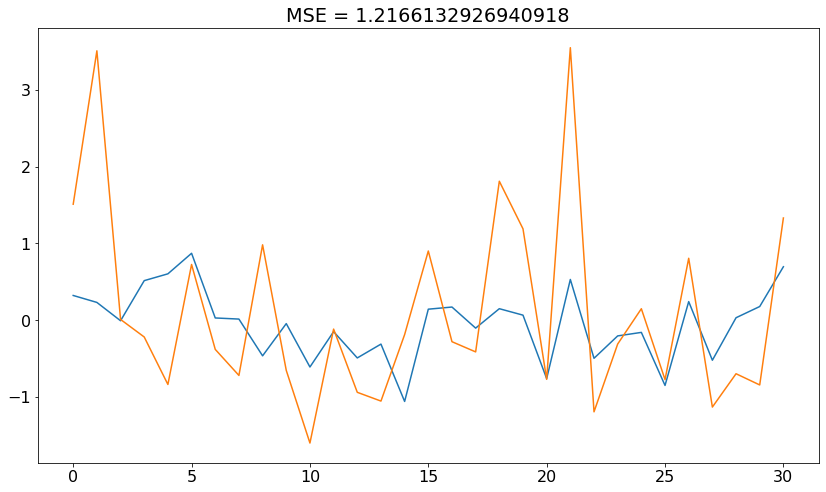

In [293]:
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'
plt.rc('font', size=16)

itera = 0
mse_test = 0.25
while mse_test > 0.2 and itera < 10:
    x_train, y_train, x_test, y_test = separate_training_testing(x_data, y_data, 120)
    n_cols = x_train.shape[1]

    model = Sequential()  # Set up the model: model
    model.add(Dense(90, activation='relu', input_shape=(n_cols,)))
    model.add(Dense(90, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, epochs=10, batch_size=20, verbose=0)
    mse_train = model.evaluate(x_train, y_train, verbose=0)
    mse_test = model.evaluate(x_test, y_test, verbose=0)
    # print(f'mse: {mse}')

    modelname = 'model3'
    model.save(modelname + '.h5')
    itera += 1
    print(f'Iteration: {itera}, MSE: {mse_test}')

y_pred = model.predict(x_train)
y_pred_test = model.predict(x_test)

# plt.figure()
# plt.plot(np.arange(len(y_pred)), y_pred)
# plt.plot(np.arange(len(y_train)), y_train)
# plt.title(f'MSE = {mse_train}')

plt.figure()
plt.plot(np.arange(len(y_pred_test)), y_pred_test)
plt.plot(np.arange(len(y_test)), y_test)
plt.title(f'MSE = {mse_test}')
plt.savefig(modelname)

# I think I need more training data ...

# In the meantime, I can try predicting all the pin powers